In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import librosa
from tqdm import tqdm

In [3]:
pickle_path = 'data/pickle'

In [4]:
import pickle
def load_pickle(filename):
    print(f'load pickle <- {filename}')
    with open(filename, 'rb') as lf:
        load_data = pickle.load(lf)
    return load_data

In [5]:
x_list = load_pickle(pickle_path+'/x.pickle')
y_list = load_pickle(pickle_path+'/y.pickle')
z_list = load_pickle(pickle_path+'/z.pickle')
combined = np.transpose((x_list,y_list,z_list))
combined.shape

load pickle <- data/pickle/x.pickle
load pickle <- data/pickle/y.pickle
load pickle <- data/pickle/z.pickle


2022-10-25 13:05:42.357831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 13:05:42.448350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-25 13:05:42.448366: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-25 13:05:42.450209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

(4618332, 3)

In [6]:
print(f'shape of combined data: {combined.shape}')
cut = combined.shape[0]//1024*1024
combined_splited = np.split(combined[:cut,:], cut/1024, axis=0)
print(f'length of combined_splited: {len(combined_splited)}')
print(f'first single shape: {combined_splited[0].shape}')
print(f'last single shape: {combined_splited[-1].shape}')

shape of combined data: (4618332, 3)
length of combined_splited: 4510
first single shape: (1024, 3)
last single shape: (1024, 3)


In [7]:
S = librosa.feature.melspectrogram(y=combined_splited[0][:,0], sr=1024, n_mels=1024)
S_dB = librosa.power_to_db(S, ref=np.max)
S_dB.shape

/home/zzh/anaconda3/envs/industry_DL3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1024
  return f(*args, **kwargs)


(1024, 3)

In [8]:
# test librosa mfcc; enlarge the shape of the result
librosa.feature.mfcc(y=np.random.rand(1024), sr=1024, n_mels=100).shape

(20, 3)

In [9]:
librosa.feature.mfcc(y=combined_splited[0][:,0], sr=1024, n_mfcc=20, n_fft=1024)
S_dB.shape

(1024, 3)

In [10]:
output_list = []
for j in tqdm(range(len(combined_splited))):
  input_mel = combined_splited[0]
  after_mel = []
  for i in range(3):
    input_axis = input_mel[:, i]
    S = librosa.feature.melspectrogram(y=combined_splited[j][:,i], sr=1024, n_fft=1024, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    after_mel.append(S_dB)

  after_mel_array = np.stack(after_mel, axis=2)
  output_list.append(after_mel_array)
after_mel_array_array = np.stack(output_list, axis=0)

100%|██████████| 4510/4510 [00:18<00:00, 241.79it/s]


In [11]:
output_list[0].shape

(128, 3, 3)

In [12]:
after_mel_array_array = np.transpose(after_mel_array_array, (0,3,1,2))
after_mel_array_array.shape
# batch_size * num_of_channels * Height * Width

(4510, 3, 128, 3)

In [13]:
loader = DataLoader(after_mel_array_array, batch_size=10, shuffle=True, num_workers=6)

In [14]:
n1 = nn.Conv2d(3, 6, 2, 1)(torch.from_numpy(after_mel_array_array[:10,:,:,:]))
print(n1.shape)
n2 = nn.BatchNorm2d(6)(n1)
print(n2.shape)
n3 = nn.LeakyReLU(0.2, inplace=True)(n2)
print(n3.shape)

torch.Size([10, 6, 127, 2])
torch.Size([10, 6, 127, 2])
torch.Size([10, 6, 127, 2])


In [15]:
n4 = nn.Conv2d(6, 12, 2, 1)(n3)
print(n4.shape)
n5 = nn.BatchNorm2d(12)(n4)
print(n5.shape)
n6 = nn.LeakyReLU(0.2, inplace=True)(n5)
print(n6.shape)

torch.Size([10, 12, 126, 1])
torch.Size([10, 12, 126, 1])
torch.Size([10, 12, 126, 1])


In [16]:
# Decoder
n7 = nn.ConvTranspose2d(12, 6, 2, 1)(n6)
print(n7.shape)
n8 = nn.BatchNorm2d(6)(n7)
print(n8.shape)
n9 = nn.LeakyReLU(0.2, inplace=True)(n8)
print(n9.shape)

torch.Size([10, 6, 127, 2])
torch.Size([10, 6, 127, 2])
torch.Size([10, 6, 127, 2])


In [17]:
n10 = nn.ConvTranspose2d(6, 3, 2, 1)(n9)
print(n10.shape)
n11 = nn.BatchNorm2d(3)(n10)
print(n11.shape)
n12 = nn.LeakyReLU(0.2, inplace=True)(n11)
print(n12.shape)

torch.Size([10, 3, 128, 3])
torch.Size([10, 3, 128, 3])
torch.Size([10, 3, 128, 3])


## Conv2d AutoEncoder

I need find a conv2d autoencoder model to train the data

In [18]:
class AutoEncoderConv2d(nn.Module):
    def __init__(self, chnum_in):
        # one parameter: number of channels
        # this project needs three channels
        super(AutoEncoderConv2d, self).__init__()
        self.chnum_in = chnum_in
        # 128 96 256
        feature_num = 12
        feature_num_2 = 6
        feature_num_x2 = 256
        self.encoder = nn.Sequential(
            nn.Conv2d(self.chnum_in,
                      feature_num_2,
                      2,
                      stride=1 #,padding=(1, 1)
                      ),
            nn.BatchNorm2d(feature_num_2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_num_2,
                      feature_num, 2,
                      stride=1#, padding=(1, 1)
                      ),
            nn.BatchNorm2d(feature_num),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(feature_num, feature_num_x2,
            #           2, stride=1, padding=(1, 1)),
            # nn.BatchNorm2d(feature_num_x2),
            # nn.LeakyReLU(0.2, inplace=True),
            #
            # nn.Conv2d(feature_num_x2, feature_num_x2,
            #           2, stride=1, padding=(1, 1)),
            # nn.BatchNorm2d(feature_num_x2),
            # nn.LeakyReLU(0.2, inplace=True)
        )

        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(feature_num_x2, feature_num_x2,
            #                    2, stride=1
            #                    #, padding=(1, 1),
            #                    #output_padding=(1, 1)
            #                    ),
            # nn.BatchNorm2d(feature_num_x2),
            # nn.LeakyReLU(0.2, inplace=True),
            #
            # nn.ConvTranspose2d(feature_num_x2, feature_num,
            #                    2, stride=1
            #                    #, padding=(1, 1),
            #                    #output_padding=(1, 1)
            #                    ),
            # nn.BatchNorm2d(feature_num),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(feature_num, feature_num_2,
                               2, stride=1
                               # , padding=(1, 1),
                               # output_padding=(1, 1)
                               ),
            nn.BatchNorm2d(feature_num_2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(feature_num_2, self.chnum_in,
                               2, stride=1
                               # , padding=(1, 1),
                               # output_padding=(0, 1)
                               )
        )

    def forward(self, x):
        f = self.encoder(x)
        out = self.decoder(f)
        return out

In [19]:
from model import conv2d
device = "cuda:0"
from model import conv2dAE, conv2d_ae
#model_conv2D = conv2dAE.ConvAutoencoder().to(device)
model_conv2D = AutoEncoderConv2d(3).to(device)
#model_conv2D = conv2d_ae.Conv2d_AE(10).to(device)
tr_recon_loss_func = nn.MSELoss().to(device)
#tr_entropy_loss_func = entropy_loss.EntropyLossEncap().to(device)
tr_optimizer = torch.optim.Adam(model_conv2D.parameters(), lr=1e-4)

cuda:0


  0%|          | 1/500 [00:01<16:32,  1.99s/it]

1775.1546011034507


 10%|█         | 51/500 [01:18<11:06,  1.49s/it]

8.993503380244693


 20%|██        | 101/500 [02:32<09:30,  1.43s/it]

5.61967765835595


 30%|███       | 151/500 [03:44<08:26,  1.45s/it]

3.110080672473442


 40%|████      | 201/500 [04:57<07:21,  1.48s/it]

2.066870725472063


 50%|█████     | 251/500 [06:10<06:02,  1.46s/it]

1.4703758470631492


 60%|██████    | 301/500 [07:22<04:45,  1.43s/it]

1.7212503784379516


 70%|███████   | 351/500 [08:34<03:34,  1.44s/it]

1.2338453964753584


 80%|████████  | 401/500 [09:45<02:21,  1.43s/it]

1.2308973896992443


 90%|█████████ | 451/500 [10:56<01:09,  1.41s/it]

1.2808951495293768


100%|██████████| 500/500 [12:07<00:00,  1.45s/it]


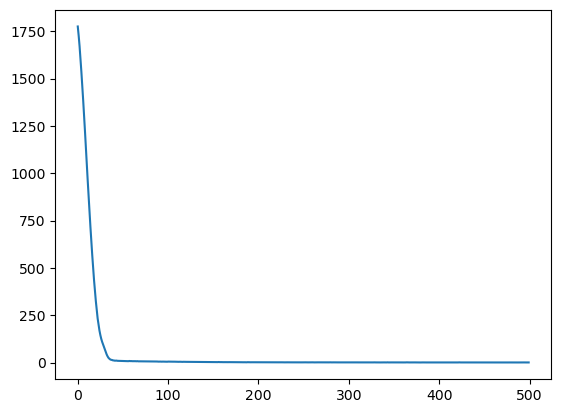

In [20]:
epochs = 500
loss_values = []
print(device)
for epoch in tqdm(range(epochs)):
    loss = 0
    for batch in loader:
        #print(f'batch shape: {batch.shape}')
        batch = batch.to(device)
        tr_optimizer.zero_grad()
        outputs = model_conv2D(batch)
        #print(f'outputs.shape: {outputs.shape}')
        train_loss = tr_recon_loss_func(outputs, batch)
        train_loss.backward()
        tr_optimizer.step()
        loss += train_loss.item()
    loss /=len(loader)
    loss_values.append(loss)
    #print(f'epoch: {epoch:03d}, loss: {loss:.4f}')
    if epoch%50==0:
        print(loss)

plt.plot(loss_values)

In [21]:
# loss_values1 = [l*0.1 for l in loss_values]
# plt.plot(loss_values1[40:])

In [22]:
len(output_list)
print(output_list[0].shape)
print(output_list[-1].shape)

(128, 3, 3)
(128, 3, 3)


In [23]:
# Only the last two months left
# I have to try my best to win the fighting.